In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import time

#Datasets generation
from sklearn.datasets import make_circles, make_blobs, make_classification

#Classification models
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RFc
from sklearn.tree import DecisionTreeClassifier as DTc
from sklearn.svm import SVC as SVMc
from sklearn.neural_network import MLPClassifier as MLPc

#GridSearch
from sklearn.model_selection import GridSearchCV

#Model metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, auc

import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_classifier_boundary(model,x,h = .05): #kindly provided in class
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = x[:, 0].min()-.2, x[:, 0].max()+.2
    y_min, y_max = x[:, 1].min()-.2, x[:, 1].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
cmap = colors.ListedColormap(['blue','orange'])

In [4]:
def Test_models(x, y, clusters=2):
    models = [LR(), LDA(), QDA(), RFc(), DTc(), SVMc(kernel='rbf'), 
              SVMc(kernel='poly'), MLPc(activation='relu'), MLPc(activation='tanh'), SVMc(kernel='linear')]
    modls = ['LR','LDA','QDA','RFc','DTc','SVMc_rbf','SVMc_poly','MLPc_relu','MLPc_tanh','SVMc_lin']
    
    grid_params_DTc = {'criterion': ['gini', 'entropy'],
        'max_depth': range(1, 10),
        'min_samples_split': range(1, 10),
        'min_samples_leaf': range(1, 5) }    
    grid_params_RFc = {"n_estimators": [10, 50, 100, 200],
             "criterion": ['gini', 'entropy'],
             "min_samples_split": [2, 5, 10, 20],
             "min_samples_leaf": [1, 2 , 5 , 10],
             "min_impurity_decrease": [0.0, 1.0, 2.0]}
    grid_params_SVMc = {'C':[0.001,0.005,0.01,0.05, 0.1,0.5, 1, 5, 10]}
    grid_params_MLPc = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
            'batch_size':[100, 50, 25]}
    if clusters > 2:
        models = models[1:]
        modls = modls[1:]
    fig = plt.figure(figsize=(30,20))
    Acc = []
    F1 = []
    Auc =  []
    T_time = []
    for i in range(len(models)):
        mod = models[i]
        if i == 4:
            grid_mod = GridSearchCV(DTc(), grid_params_DTc, verbose=1, cv=5, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x, y)
            mod = grid_mod.best_estimator_
        elif i == 3:
            grid_mod = GridSearchCV(RFc(random_state=42), grid_params_RFc, verbose=1, cv=5, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x, y)
            mod = grid_mod.best_estimator_
        elif i == 5:
            grid_mod = GridSearchCV(SVMc(kernel='rbf'), grid_params_SVMc, verbose=1, cv=5, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x, y)
            mod = grid_mod.best_estimator_
        elif i == 6:
            grid_mod = GridSearchCV(SVMc(kernel='poly'), grid_params_SVMc, verbose=1, cv=5, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x, y)
            mod = grid_mod.best_estimator_
        elif i == 7:
            grid_mod = GridSearchCV(MLPc(activation='relu'), grid_params_MLPc, verbose=1, cv=5, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x, y)
            mod = grid_mod.best_estimator_
        elif i == 8:
            grid_mod = GridSearchCV(MLPc(activation='tanh'), grid_params_MLPc, verbose=1, cv=5, n_jobs=-1, scoring = 'f1')    
            grid_mod.fit(x, y)
            mod = grid_mod.best_estimator_
        elif i == 9:
            grid_mod = GridSearchCV(SVMc(kernel='linear'), grid_params_SVMc, verbose=1, cv=5, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x, y)
            mod = grid_mod.best_estimator_
        else:
            mod = models[i]
        start = time.time()
        mod.fit(x, y)
        stop = time.time()

        print(mod)
        print('Accuracy:', cross_val_score(mod, x, y, cv=5, scoring=('accuracy')))
        Acc.append(np.mean(cross_val_score(mod, x, y, cv=5, scoring=('accuracy'))))
        print('F1:', cross_val_score(mod, x, y, cv=5, scoring=('f1')))
        F1.append(np.mean(cross_val_score(mod, x, y, cv=5, scoring=('f1'))))
        print('AUC:', cross_val_score(mod, x, y, cv=5, scoring=('roc_auc')))
        Auc.append(np.mean(cross_val_score(mod, x, y, cv=5, scoring=('roc_auc'))))

        print(f"Training time: {stop - start}s")
        T_time.append(stop-start)
        print('\n')

        ax = fig.add_subplot(4, 4, i+1)
        plot_classifier_boundary(mod,x)
        ax.scatter(x[:,0],x[:,1],color=cmap(y))
        ax.set_title(models[i], fontsize = 13)
        ax.set_xlabel('$x1$')
        ax.set_ylabel('$x2$')

    Metrics = [Acc, F1, Auc, T_time]
    Labels = ['Accuracy score', 'F1', 'AUC', 'Training time']
    for i in range(4):
        ax = fig.add_subplot(4, 4, i+13) 
        ax.barh(modls, Metrics[i])
        ax.set_xlabel(Labels[i])
    plt.show() 


LogisticRegression()
Accuracy: [1. 1. 1. 1. 1.]
F1: [1. 1. 1. 1. 1.]
AUC: [1. 1. 1. 1. 1.]
Training time: 0.005983114242553711s


LinearDiscriminantAnalysis()
Accuracy: [1. 1. 1. 1. 1.]
F1: [1. 1. 1. 1. 1.]
AUC: [1. 1. 1. 1. 1.]
Training time: 0.0019919872283935547s


QuadraticDiscriminantAnalysis()
Accuracy: [1. 1. 1. 1. 1.]
F1: [1. 1. 1. 1. 1.]
AUC: [1. 1. 1. 1. 1.]
Training time: 0.0009970664978027344s


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
RandomForestClassifier(n_estimators=10, random_state=42)
Accuracy: [1. 1. 1. 1. 1.]
F1: [1. 1. 1. 1. 1.]
AUC: [1. 1. 1. 1. 1.]
Training time: 0.010970830917358398s


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
DecisionTreeClassifier(max_depth=1)
Accuracy: [1. 1. 1. 1. 1.]
F1: [1. 1. 1. 1. 1.]
AUC: [1. 1. 1. 1. 1.]
Training time: 0.000997304916381836s


Fitting 5 folds for each of 45 candidates, totalling 225 fits
SVC(C=0.001, gamma=0.0001)
Accuracy: [1. 1. 1. 1. 1.]
F1: [1. 1. 1. 1. 1.]
AUC: [1. 1. 1

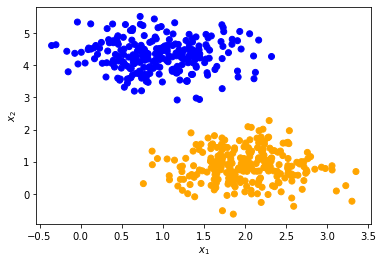

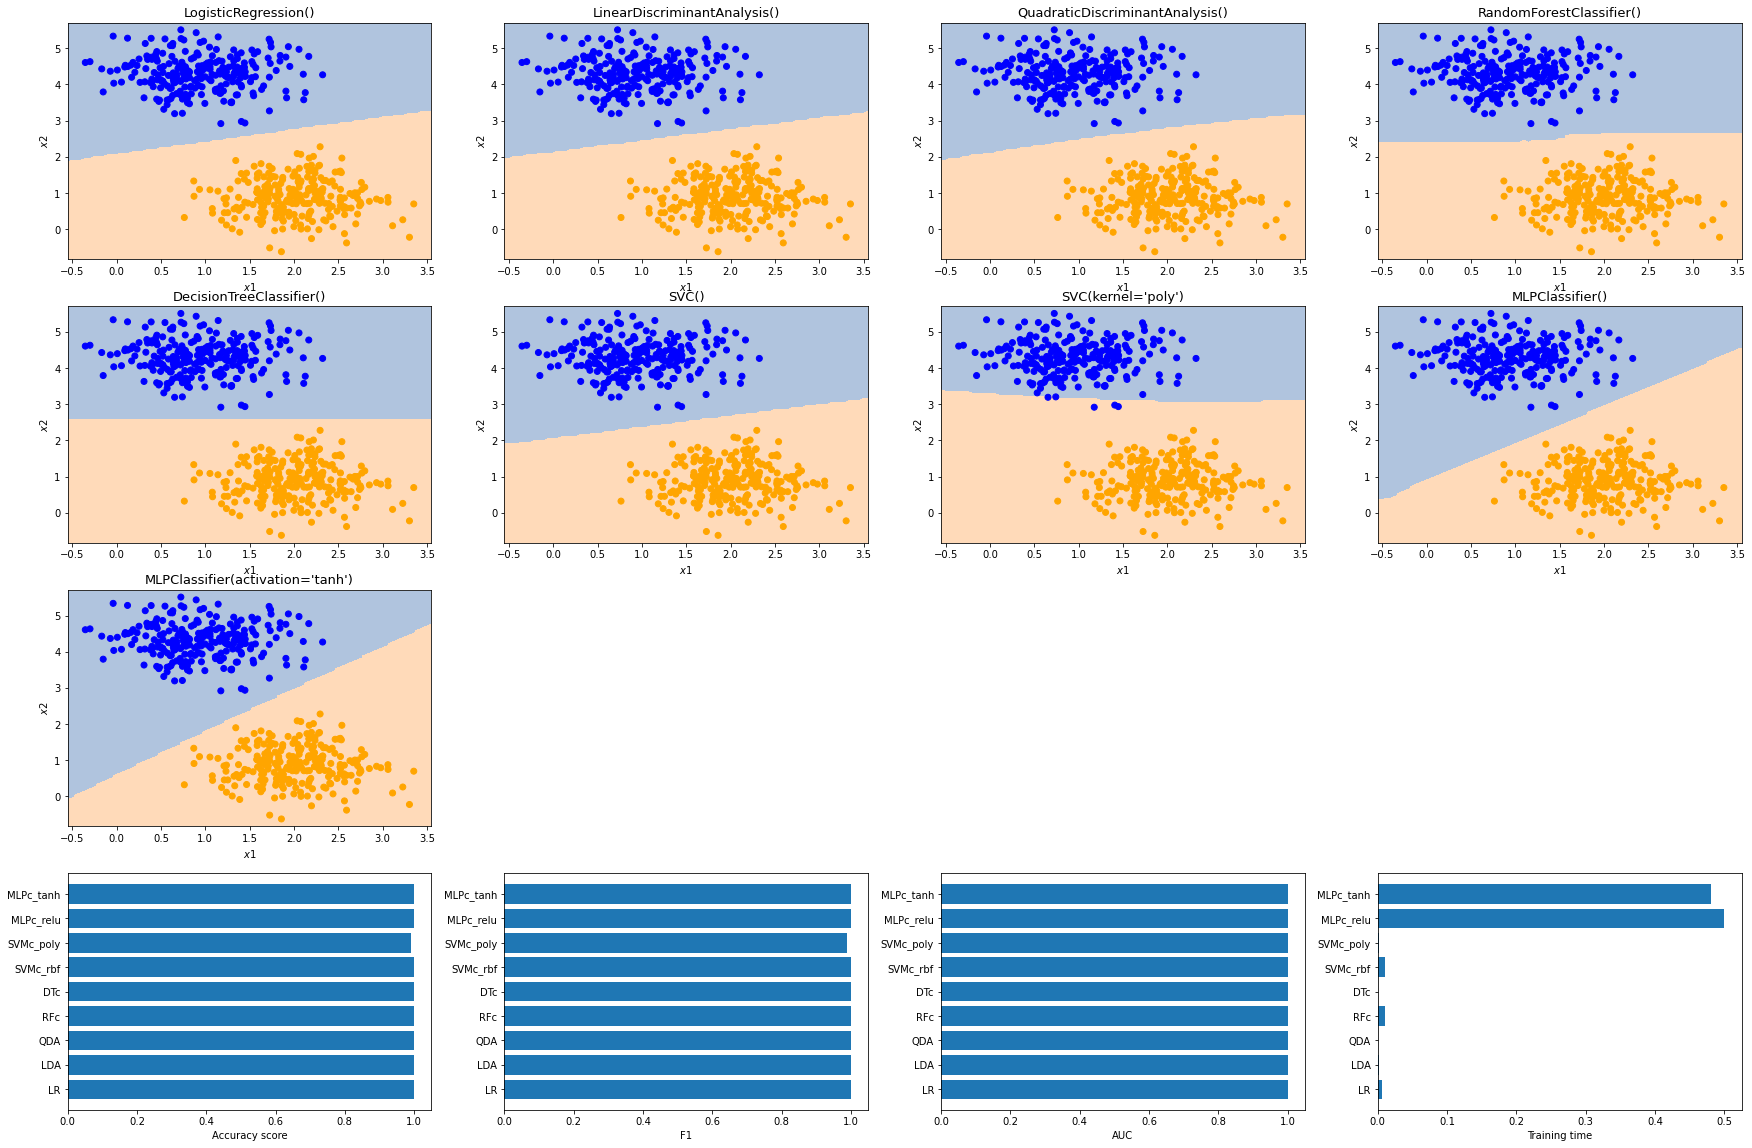

In [4]:
x, y = make_blobs(n_samples=500, centers=2, n_features=2, 
                  cluster_std=0.5, random_state=0)
ax=plt.axes()
ax.scatter(x[:,0],x[:,1],color=cmap(y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Test_models(x, y)

LogisticRegression()
Accuracy: [0.95 0.95 0.96 0.98 0.98]
F1: [0.94949495 0.95145631 0.96       0.98       0.97959184]
AUC: [0.9948 0.99   0.9932 0.9928 0.9988]
Training time: 0.003957271575927734s


LinearDiscriminantAnalysis()
Accuracy: [0.95 0.95 0.96 0.97 0.98]
F1: [0.94949495 0.95145631 0.96       0.96969697 0.97959184]
AUC: [0.994  0.9916 0.9936 0.9928 0.9984]
Training time: 0.000997304916381836s


QuadraticDiscriminantAnalysis()
Accuracy: [0.95 0.95 0.96 0.97 0.98]
F1: [0.94949495 0.95145631 0.96       0.96969697 0.97959184]
AUC: [0.9948 0.9916 0.9936 0.9924 0.9984]
Training time: 0.0s


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
RandomForestClassifier(criterion='entropy', min_samples_split=20,
                       n_estimators=200, random_state=42)
Accuracy: [0.96 0.97 0.98 0.94 0.98]
F1: [0.96       0.97029703 0.98       0.94117647 0.97959184]
AUC: [0.9928 0.9932 0.9932 0.9892 0.9968]
Training time: 0.22539591789245605s


Fitting 5 folds for each of 648 

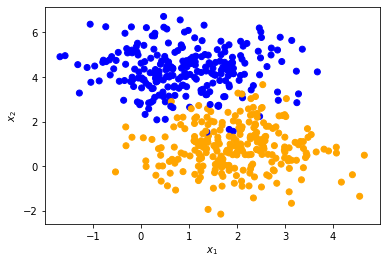

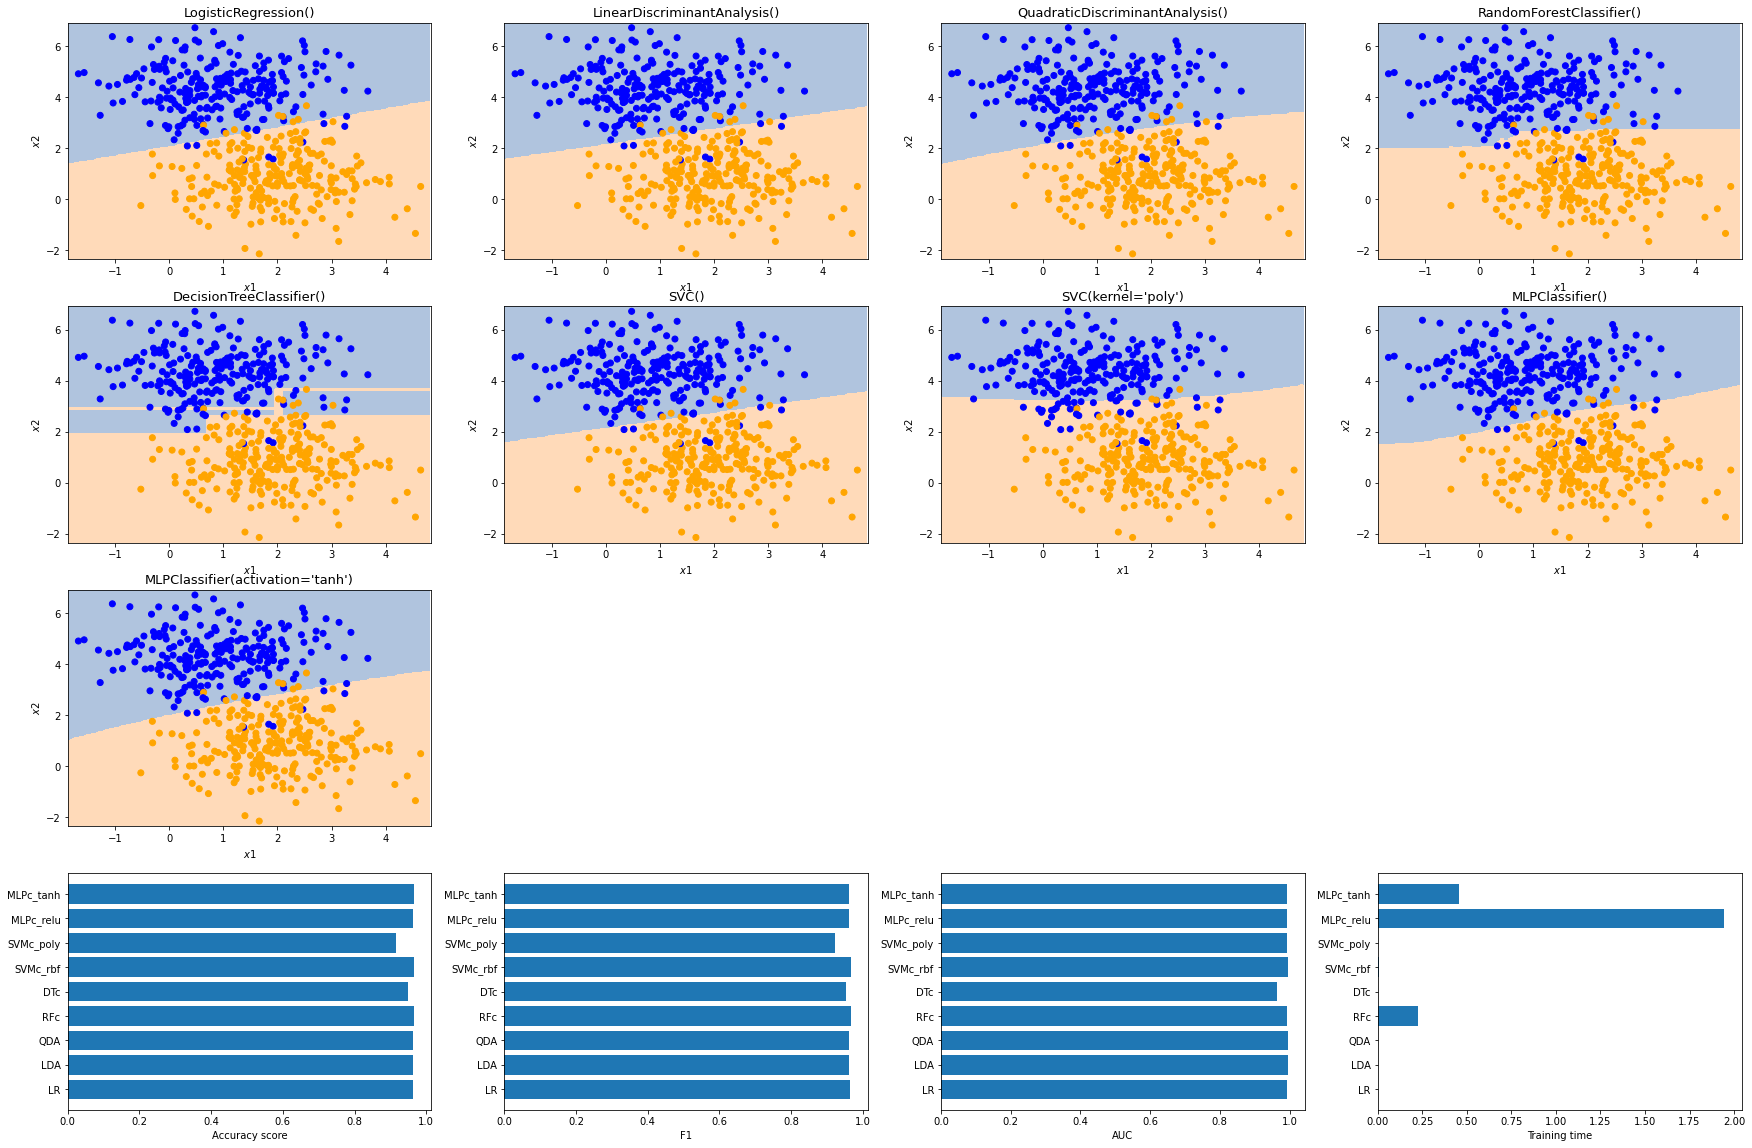

In [5]:
x, y = make_blobs(n_samples=500, centers=2, n_features=2, 
                  cluster_std=1, random_state=0)
ax=plt.axes()
ax.scatter(x[:,0],x[:,1],color=cmap(y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Test_models(x, y)

LogisticRegression()
Accuracy: [0.99 0.98 0.96 0.96 0.94]
F1: [0.99029126 0.98076923 0.96153846 0.96       0.94230769]
AUC: [0.99959984 0.99239696 0.9892     0.972      0.9716    ]
Training time: 0.002961874008178711s


LinearDiscriminantAnalysis()
Accuracy: [0.98 0.98 0.9  0.96 0.94]
F1: [0.98076923 0.98076923 0.90909091 0.96       0.94230769]
AUC: [1.         0.99319728 0.9864     0.9716     0.9752    ]
Training time: 0.0s


QuadraticDiscriminantAnalysis()
Accuracy: [0.99 0.98 0.98 0.97 0.96]
F1: [0.99029126 0.98076923 0.98039216 0.96969697 0.96078431]
AUC: [1.        0.9959984 0.9928    0.9716    0.97     ]
Training time: 0.0s


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
RandomForestClassifier(criterion='entropy', min_samples_leaf=5, n_estimators=10,
                       random_state=42)
Accuracy: [1.   0.98 0.99 0.97 0.91]
F1: [1.         0.98039216 0.99009901 0.96969697 0.91588785]
AUC: [1.         0.99239696 0.9872     0.9812     0.9732    ]
Training time: 

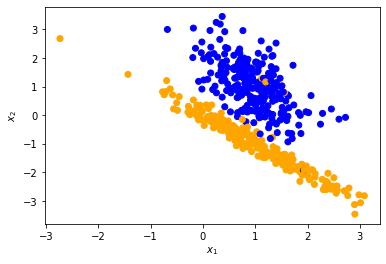

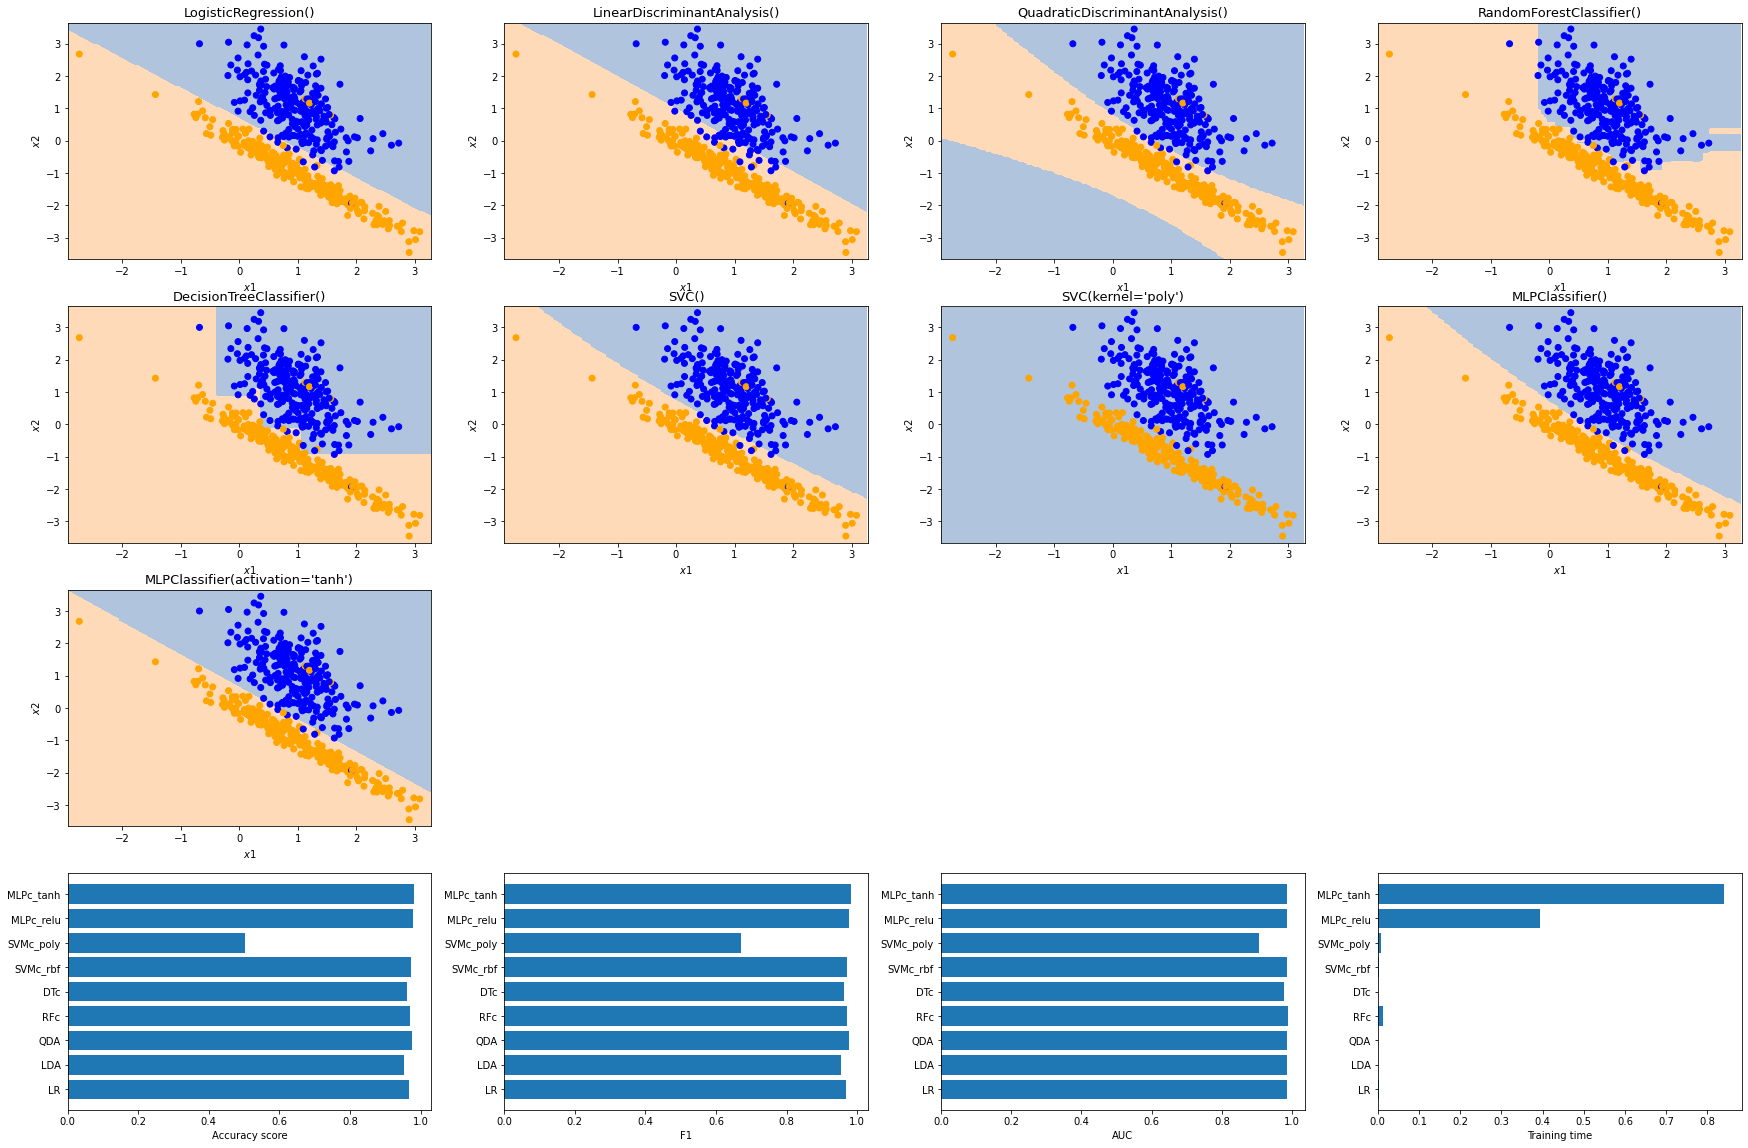

In [6]:
x,y = make_classification(n_samples=500,n_features=2,
                          n_classes=2,
                          n_clusters_per_class=1,
                          n_redundant=0,class_sep=1,
                          random_state=1,weights=(0.5,))

ax=plt.axes()
ax.scatter(x[:,0],x[:,1],color=cmap(y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Test_models(x, y)

LogisticRegression()
Accuracy: [0.99 0.96 0.98 0.97 0.98]
F1: [0.95238095 0.81818182 0.88888889 0.82352941 0.90909091]
AUC: [1.         0.9918284  0.92222222 0.87666667 0.98      ]
Training time: 0.0029916763305664062s


LinearDiscriminantAnalysis()
Accuracy: [0.99 0.96 0.99 0.97 0.97]
F1: [0.95652174 0.81818182 0.94736842 0.84210526 0.86956522]
AUC: [1.         0.9918284  0.92       0.87111111 0.98222222]
Training time: 0.0s


QuadraticDiscriminantAnalysis()
Accuracy: [0.99 0.96 0.99 0.98 0.98]
F1: [0.95652174 0.81818182 0.94736842 0.88888889 0.90909091]
AUC: [0.9979571  0.9959142  0.91666667 0.86777778 0.98111111]
Training time: 0.0s


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
RandomForestClassifier(n_estimators=50, random_state=42)
Accuracy: [0.98 0.96 0.98 0.98 0.98]
F1: [0.90909091 0.81818182 0.88888889 0.88888889 0.90909091]
AUC: [0.9918284  0.96118488 0.93555556 0.87888889 0.98777778]
Training time: 0.05488085746765137s


Fitting 5 folds for each of 648 can

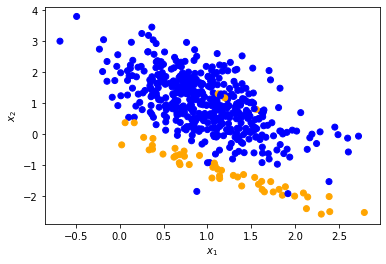

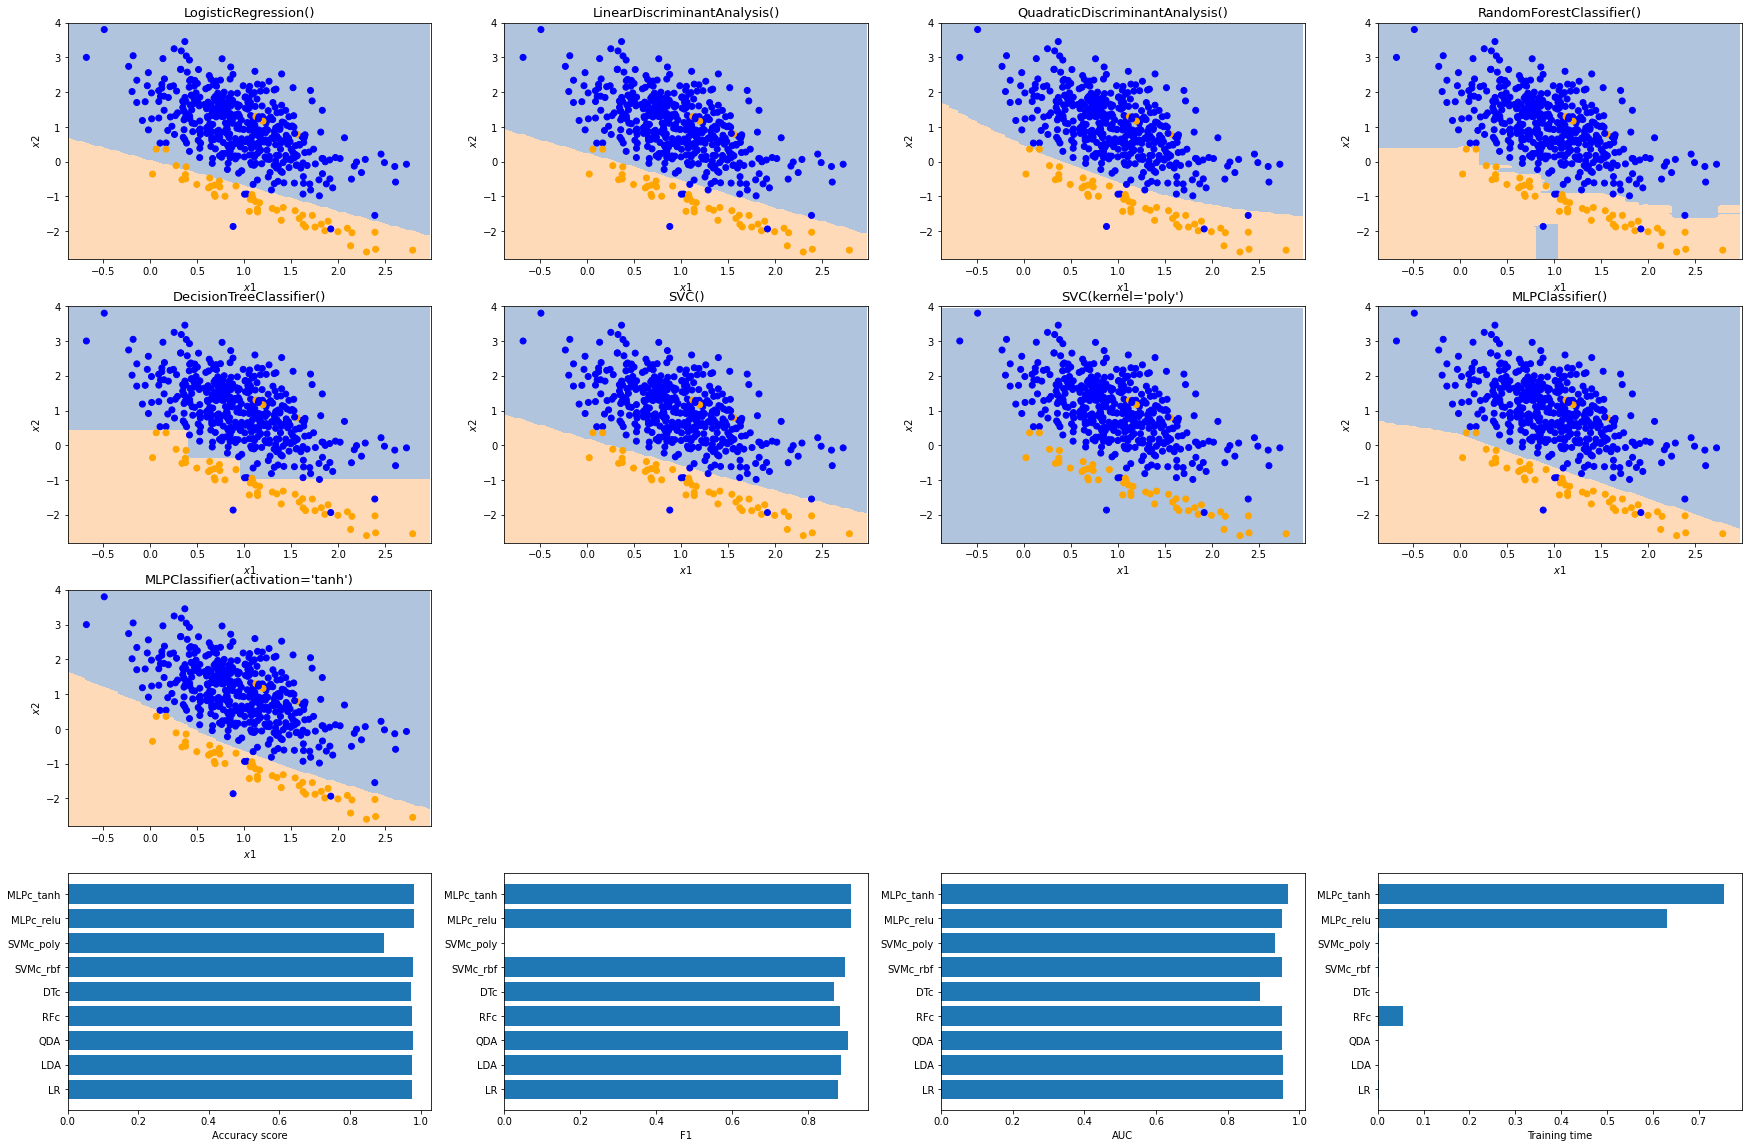

In [7]:
x,y = make_classification(n_samples=500,n_features=2,
                          n_classes=2,
                          n_clusters_per_class=1,
                          n_redundant=0,class_sep=1,
                          random_state=1,weights=(0.9,))
ax=plt.axes()
ax.scatter(x[:,0],x[:,1],color=cmap(y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Test_models(x, y)

LogisticRegression()
Accuracy: [0.37 0.44 0.39 0.46 0.46]
F1: [0.33684211 0.41666667 0.35789474 0.5        0.48076923]
AUC: [0.43   0.4484 0.39   0.3964 0.454 ]
Training time: 0.0019948482513427734s


LinearDiscriminantAnalysis()
Accuracy: [0.37 0.44 0.39 0.46 0.45]
F1: [0.33684211 0.41666667 0.35789474 0.5        0.46601942]
AUC: [0.43   0.4488 0.39   0.3964 0.454 ]
Training time: 0.0009970664978027344s


QuadraticDiscriminantAnalysis()
Accuracy: [0.89 0.92 0.85 0.88 0.8 ]
F1: [0.89108911 0.91666667 0.84536082 0.88235294 0.8       ]
AUC: [0.9576 0.95   0.9416 0.9536 0.9028]
Training time: 0.0s


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
RandomForestClassifier(criterion='entropy', min_samples_leaf=10,
                       n_estimators=200, random_state=42)
Accuracy: [0.9  0.89 0.87 0.87 0.82]
F1: [0.90196078 0.88659794 0.86597938 0.87619048 0.81632653]
AUC: [0.9504 0.9568 0.9236 0.9296 0.8718]
Training time: 0.26927900314331055s


Fitting 5 folds for each of 648

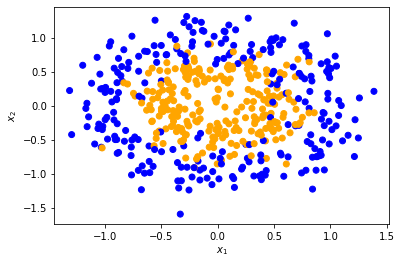

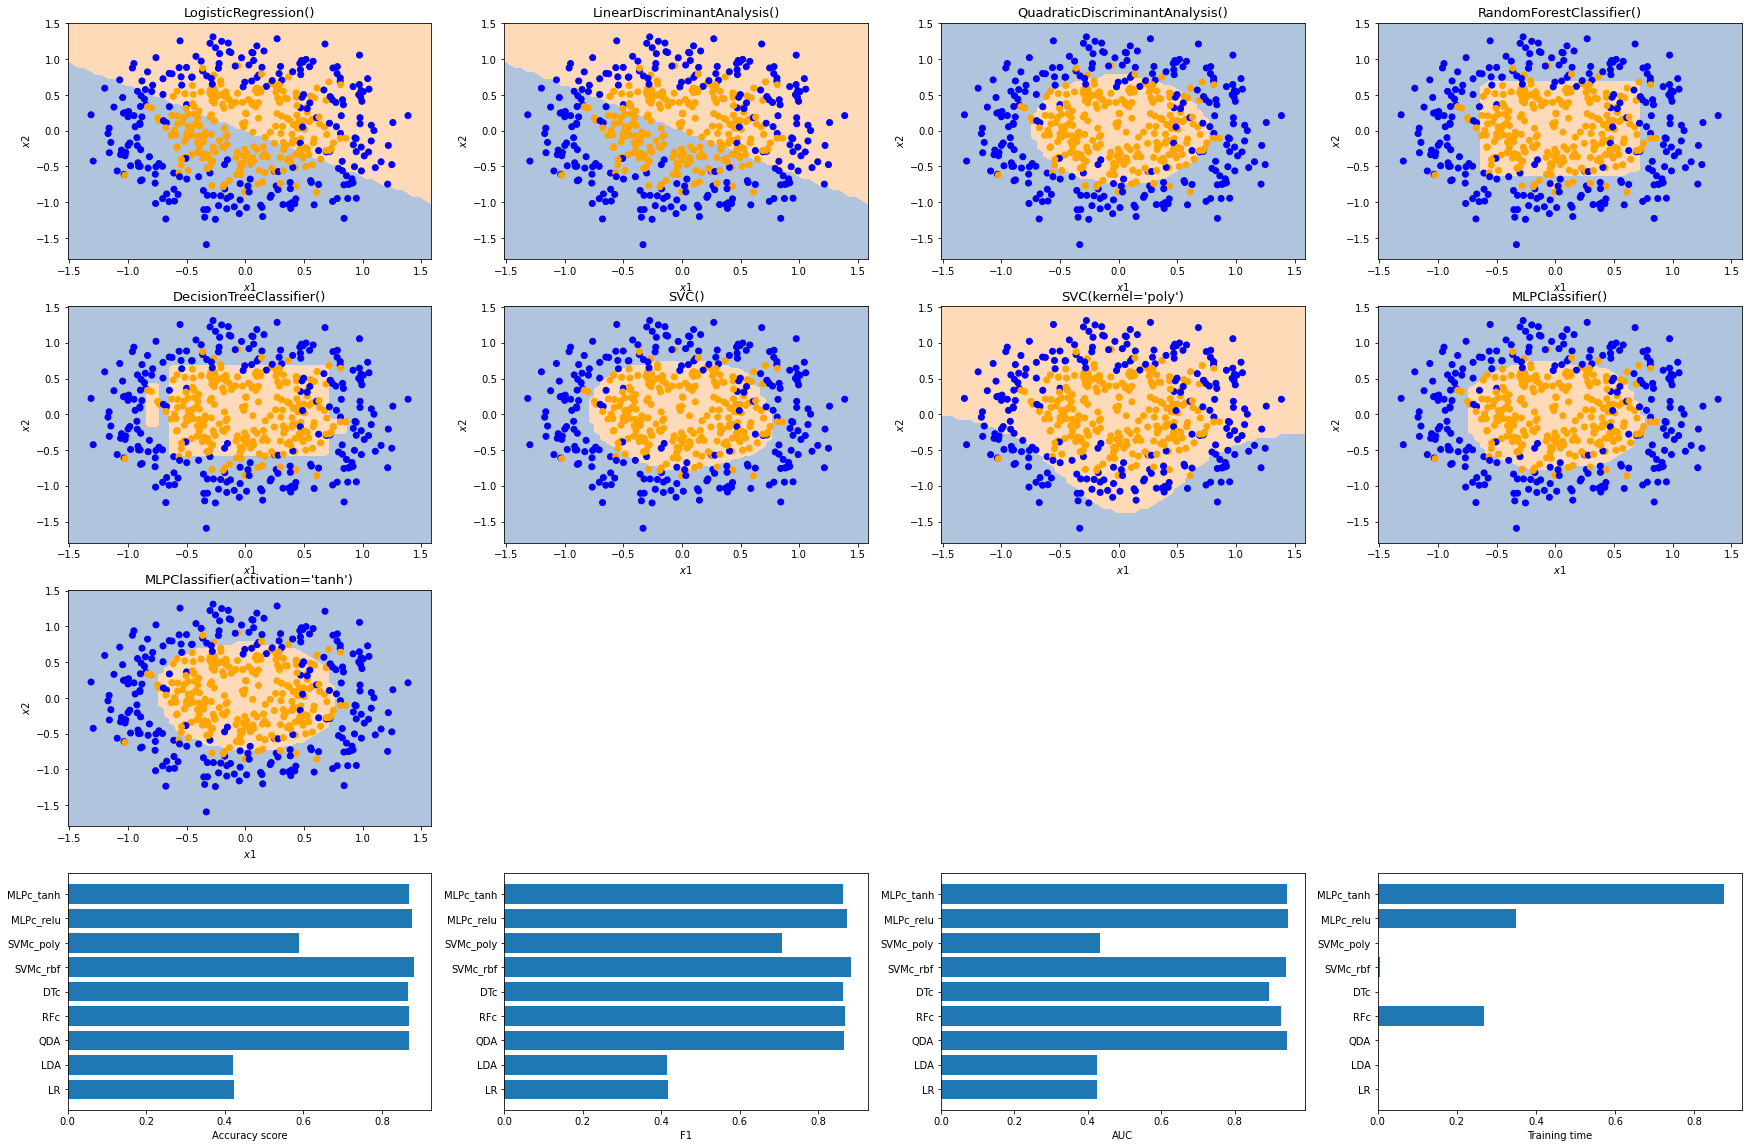

In [33]:
x,y = make_circles(n_samples=500,
                          random_state=1,
                          noise=0.2,
                          factor=0.5)

ax=plt.axes()
ax.scatter(x[:,0],x[:,1],color=cmap(y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Test_models(x, y)

LogisticRegression()
Accuracy: [0.43 0.43 0.39 0.45 0.46]
F1: [0.41237113 0.4        0.38383838 0.46601942 0.48076923]
AUC: [0.43   0.4364 0.3868 0.3924 0.4588]
Training time: 0.001993894577026367s


LinearDiscriminantAnalysis()
Accuracy: [0.43 0.43 0.39 0.45 0.46]
F1: [0.41237113 0.4        0.38383838 0.46601942 0.48076923]
AUC: [0.43   0.4364 0.3872 0.3924 0.4588]
Training time: 0.0009968280792236328s


QuadraticDiscriminantAnalysis()
Accuracy: [1.   1.   1.   1.   0.99]
F1: [1.         1.         1.         1.         0.98989899]
AUC: [1. 1. 1. 1. 1.]
Training time: 0.000997304916381836s


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42)
Accuracy: [1.   1.   0.97 1.   0.98]
F1: [1.         1.         0.96907216 1.         0.97959184]
AUC: [1. 1. 1. 1. 1.]
Training time: 0.05981183052062988s


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
DecisionTreeClassifier(criterion='en

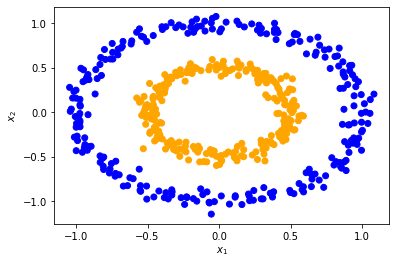

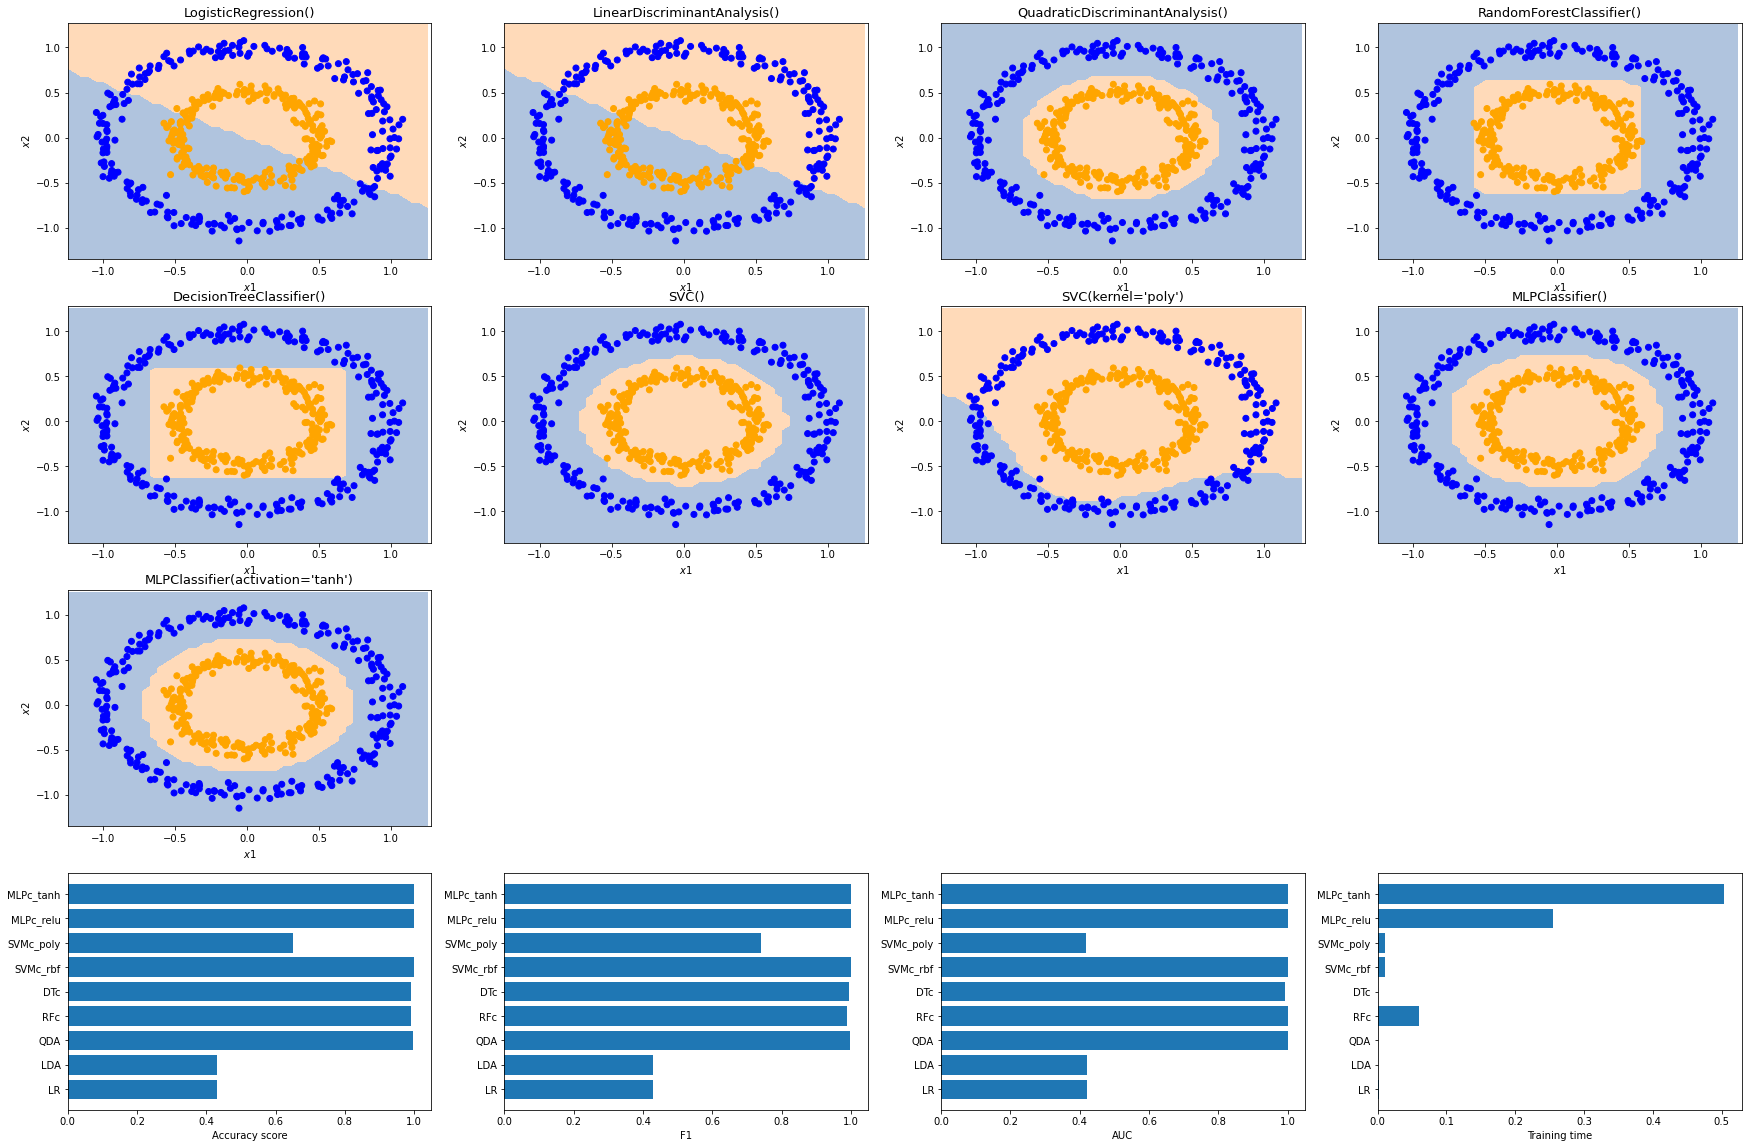

In [32]:
x,y = make_circles(n_samples=500,
                          random_state=1,
                          noise=0.05,
                          factor=0.5)

ax=plt.axes()
ax.scatter(x[:,0],x[:,1],color=cmap(y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Test_models(x, y)

LogisticRegression()
Accuracy: [0.492 0.469 0.475 0.462 0.494]
F1: [0.50487329 0.48296008 0.47864945 0.46626984 0.50585938]
AUC: [0.47746  0.453472 0.477272 0.44956  0.49094 ]
Training time: 0.043283700942993164s


LinearDiscriminantAnalysis()
Accuracy: [0.492 0.469 0.475 0.462 0.495]
F1: [0.50487329 0.48296008 0.47864945 0.46626984 0.50731707]
AUC: [0.477404 0.453472 0.477264 0.449572 0.490924]
Training time: 0.036789655685424805s


QuadraticDiscriminantAnalysis()
Accuracy: [0.896 0.895 0.896 0.904 0.878]
F1: [0.89537223 0.89361702 0.89366053 0.90041494 0.8744856 ]
AUC: [0.963988 0.9618   0.96322  0.961752 0.947752]
Training time: 0.004012584686279297s


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
RandomForestClassifier(min_samples_leaf=2, min_samples_split=20,
                       n_estimators=50, random_state=42)
Accuracy: [0.888 0.893 0.895 0.891 0.875]
F1: [0.88822355 0.89267803 0.89340102 0.88978766 0.87309645]
AUC: [0.956058 0.9574   0.954262 0.953    0.937

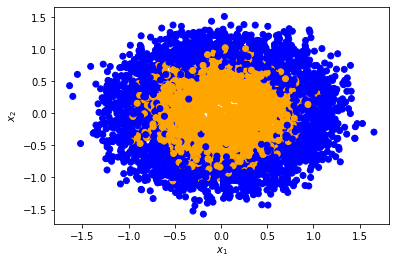

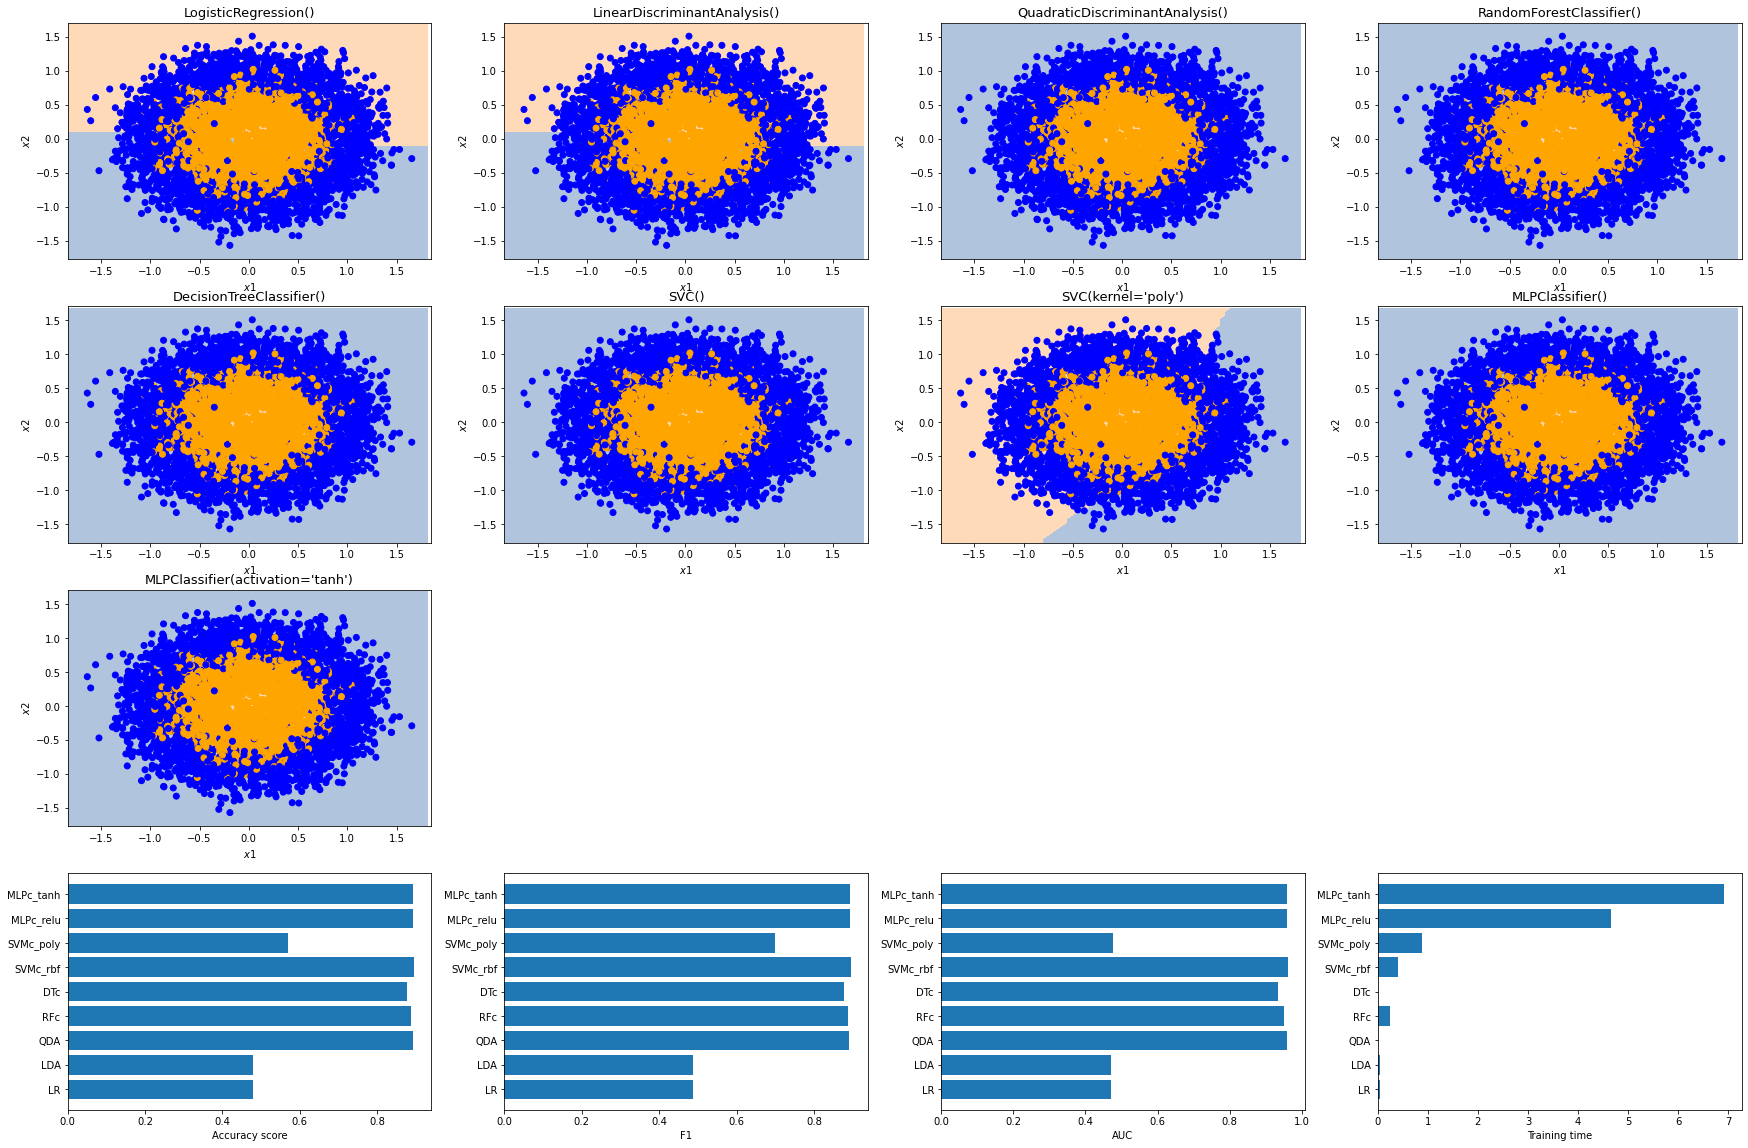

In [4]:
x,y = make_circles(n_samples=5000,
                          random_state=1,
                          noise=0.2,
                          factor=0.5)

ax=plt.axes()
ax.scatter(x[:,0],x[:,1],color=cmap(y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Test_models(x, y)

#### 2D Balanced Gaussian Quantiles: hard + enclave

In [ ]:
# Cluster 1
X1, y1 = make_gaussian_quantiles(cov=1.,
                                 n_samples=10000, n_features=2,
                                 n_classes=2, random_state=1)

# Cluster 2

X2, y2 = make_gaussian_quantiles(mean=(5,5), cov=3.,
                                 n_samples=10000, n_features=2,
                                 n_classes=2, random_state=1)


X=np.concatenate((X1,X2), axis=0)
y=np.concatenate((-y1+1,y2),axis=0)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot()

cmp = colors.ListedColormap(["Blue", "Orange"])

ax1.scatter(X[:,0], X[:,1], c= cmp(y))
ax1.set_title("2D Gaussian-distributed classes: hard + enclave")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

plt.show()

Test_models(X, y)

####  2D Balanced Gaussian Blobs

In [ ]:
# Intersected: hard-ish

X2,y2 = make_blobs(n_samples=1000, n_features=2,
                centers=[(5,5), (5,7)], cluster_std=[1,1],
                random_state=1)

Test_models(X2, y2)

In [ ]:
# Intersected: hard

X3,y3 = make_blobs(n_samples=1000, n_features=2,
                centers=[(5,5), (5,4)], cluster_std=[1,3],
                random_state=1)

Test_models(X3, y3)

#### 2D Unbalanced Gaussian Blobs: Separated & Intersected

In [ ]:
# Separated, unbalanced 5%

X1,y1 = make_blobs(n_samples=[950,50], n_features=2,
                centers=[(2,2), (5,7)], cluster_std=[1,1],
                random_state=1)

# Separated, unbalanced 1%

X2,y2 = make_blobs(n_samples=[990,10], n_features=2,
                centers=[(2,2), (5,7)], cluster_std=[1,1],
                random_state=1)

# Separated, unbalanced 0.1% 

X3,y3 = make_blobs(n_samples=[999,1], n_features=2,
                centers=[(2,2), (5,7)], cluster_std=[1,1],
                random_state=1)

# Separated, unbalanced 5%: distal subclusters

X4,y4 = make_blobs(n_samples=[950,25,25], n_features=2,
                centers=[(2,2), (7,6), (7,2)], cluster_std=[1,0.5,0.5],
                random_state=1)

# Intersected, unbalanced 5%

X5,y5 = make_blobs(n_samples=[950,50], n_features=2,
                centers=[(5,5), (5,6)], cluster_std=[0.5,0.5],
                random_state=1)

# Intersected, unbalanced 5%: subclusters

X6,y6 = make_blobs(n_samples=[950,25,25], n_features=2,
                centers=[(3,2), (2,2), (7,2)], cluster_std=[1,0.5,0.5],
                random_state=1)

for x,y in ((X1,y1),(X2,y2),(X3,y3),(X4,y4),(X5,y5),(X6,y6)):
    Test_models(x, y)

### make_circles

In [ ]:
# Well Separated, balanced Circles: noiseless

X1,y1 = make_circles(n_samples=1000, noise=None,
                     factor=0.8, random_state=1)

# Well Separated, balanced Circles: noisy

X2,y2 = make_circles(n_samples=1000, noise=0.1,
                     factor=0.1, random_state=1)

# Well Separated-ish, balanced Circles: noisy

X3,y3 = make_circles(n_samples=1000, noise=0.15,
                     factor=0.5, random_state=1)

# Poorly Separated, balanced Circles: noisy

X4,y4 = make_circles(n_samples=1000, noise=0.25,
                     factor=0.6, random_state=1)

for x,y in ((X1,y1),(X2,y2),(X3,y3),(X4,y4)):
    Test_models(x, y)

### make_moons

In [ ]:
# Well Separated, balanced moons: noiseless

X1,y1 = make_moons(n_samples=1000, noise=None, random_state=1)

# Well Separated, balanced moons: noisy

X2,y2 = make_moons(n_samples=1000, noise=0.1,
                     random_state=1)

# Well Separated-ish, balanced moons: noisy

X3,y3 = make_moons(n_samples=1000, noise=0.15,
                     random_state=1)

# Poorly Separated, balanced moons: noisy

X4,y4 = make_moons(n_samples=1000, noise=0.25,
                    random_state=1)

for x,y in ((X1,y1),(X2,y2),(X3,y3),(X4,y4)):
    Test_models(x, y)

### Circle vs spread

In [ ]:
X1,y1 = make_classification(n_classes=1,n_samples=500, n_features=2, class_sep=3,
                          n_informative=2, n_redundant=0,
                          n_repeated=0, n_clusters_per_class=1,
                          flip_y=0.1, weights=[1],random_state=1)

X2,y2 = make_circles(n_samples=500, factor=0.9,noise=0.1, random_state=1)

X2_0 = X2[np.where(y2==1)]+2.5
y2_0 = y2[np.where(y2==1)]

X = np.concatenate((X1,X2_0),axis=0)
y = np.concatenate((y1,y2_0),axis=0)


Test_models(X, y)

### Sin vs Cos: noiseless

In [ ]:
random_state = np.random.RandomState(seed=1)

# Sine
x1 = np.linspace(0,12, 500)*30; y1 = np.sin(np.radians(x1)); 

#Cosine
x2 = np.linspace(0,12, 500)*30; y2 = np.cos(np.radians(x2));

X1=np.concatenate((x1,x2),axis=0)
X2=np.concatenate((y1,y2), axis=0)

# Feature matrix and target array
X=np.c_[X1,X2]
y=np.array([0]*500 + [1]*500)

Test_models(X, y)

### Sin vs Cos: noisy

[Text(0.5, 1.0, 'Sine vs Cosine'),
 Text(0.5, 0, '$x_1$'),
 Text(0, 0.5, '$x_2$')]

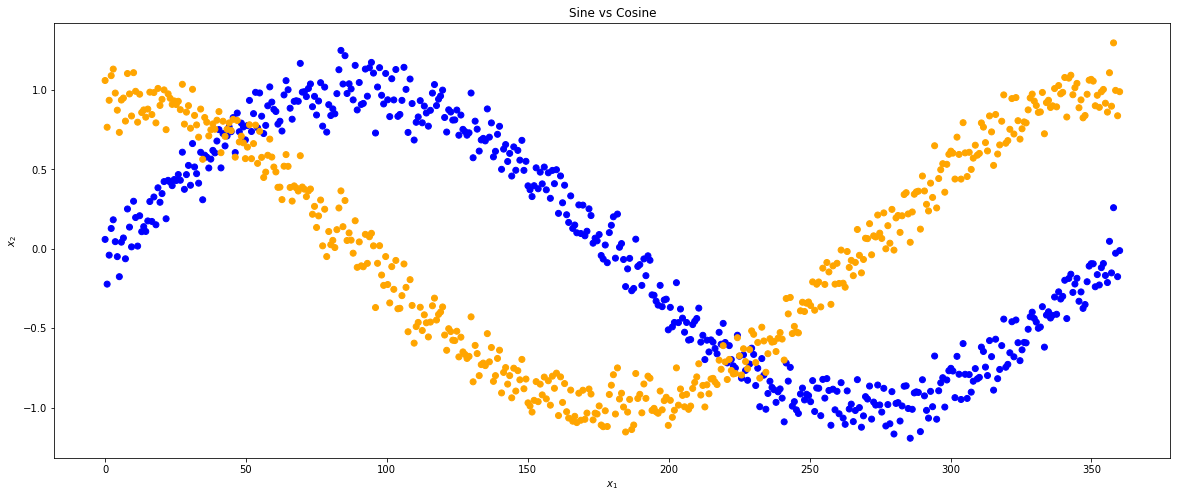

In [13]:
random_state = np.random.RandomState(seed=1)

noise=np.random.standard_normal(size=(500))/10

# Sine
x1 = np.linspace(0,12, 500)*30; y1 = np.sin(np.radians(x1))+noise; 

#Cosine
x2 = np.linspace(0,12, 500)*30; y2 = np.cos(np.radians(x2))+noise;

X1=np.concatenate((x1,x2),axis=0)
X2=np.concatenate((y1,y2), axis=0)

# Feature matrix and target array
X=np.c_[X1,X2]
y=np.array([0]*500 + [1]*500)

Test_models(X, y)

In [6]:
noise

array([-1.22098845, -1.25222363, -1.08238635, -1.3588902 ,  1.34571443,
       -1.12058709,  1.24041617,  1.20750276,  0.40308338, -0.37614485,
       -0.13945579, -0.0131694 , -0.82470558, -0.1837728 ,  2.36838018,
        0.8956551 ,  0.2153258 , -1.24633975, -0.63664475, -0.72436646,
        0.43569551,  0.12607548, -0.49132046,  0.79961856, -0.00704116,
        2.70241342, -1.36766025, -1.1757428 , -0.32172267, -0.42605853,
       -1.50179737,  0.79598962, -1.56587309, -1.94687301, -0.70824712,
       -1.03578504,  0.08967265,  1.10598179,  0.95214356, -0.03040624,
       -0.70017575, -0.01274937,  1.058474  ,  1.60822651,  1.27307905,
       -0.74131548, -1.43286958, -0.83127804,  0.49411526,  0.04630991,
       -0.44768951,  0.80907908,  1.1488173 ,  0.14595149,  1.07950963,
       -1.45978062,  1.68604409,  0.22918193,  1.41882783, -0.41221001,
       -0.24714954, -0.09879967, -0.1619874 , -1.16467178, -0.98638281,
       -1.01181393, -2.42988827, -1.3228744 , -0.23462228,  0.72